## Naive Bayes Video Classifier
This notebook runs through YouTube Trending Video the classification of YouTube Trending video category based on title using Naive Bayes.

Additionally, we will compare the performance of two specific variants of Navive Bayes
    1. Multinomial Naive Bayes
    2. Bernouli Naive Bayes

In [1]:
import pandas as pd
import seaborn as sns
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from yellowbrick.text import FreqDistVisualizer

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from yellowbrick.classifier import ROCAUC

import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline


C:\Users\lukev\Anaconda3\envs\yt-trends\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

### Load in filtered dataset and look at the formatting
The columns of interest at ['filter_title', 'filter_title_no_stops', 'category_id']
    1. 'filter_title' --> raw input that only has punctuation removed and letters to lower case
    2. 'filter_title_no_stops' --> 'filter_title' data with addition to removal of stopwords
    3. 'category_id' --> output/buckets to categorize video (16 total)

In [3]:
df_titles_info = pd.read_csv('./output/US_count_vectorizer_dataset.csv')
df_titles_info.head()

,title,filter_title,filter_title_no_stops,category_id
0,WE WANT TO TALK ABOUT OUR MARRIAGE,we want to talk about our marriage,want talk marriage,People & Blogs
1,The Trump Presidency: Last Week Tonight with J...,the trump presidency last week tonight with jo...,trump presidency last week tonight john oliver...,Entertainment
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",racist superman rudy mancuso king bach lele pons,racist superman rudy mancuso king bach lele pons,Comedy
3,Nickelback Lyrics: Real or Fake?,nickelback lyrics real or fake,nickelback lyrics real fake,Entertainment
4,I Dare You: GOING BALD!?,i dare you going bald,dare going bald,Entertainment


### Separate the dataframe into inputs and outputs

In [4]:
df_x = df_titles_info['filter_title']
df_y = df_titles_info['category_id']
df_x_stop = df_titles_info['filter_title_no_stops']

target_names = list(df_titles_info['category_id'].unique())

### Split dataset before vectorizing
This guards against leaking information from testing to training set (80% training, 20% testing)

https://machinelearningmastery.com/data-leakage-machine-learning/
https://stackoverflow.com/questions/54491953/can-i-use-countvectorizer-on-both-test-and-train-data-at-the-same-time-or-do-i-n

In [5]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=117)
x_train_stop, x_test_stop = train_test_split(df_x_stop, test_size=0.2, random_state=117)

x_train_stop = x_train_stop.fillna(' ')
x_test_stop = x_test_stop.fillna(' ')
print("Training data size:", x_train.shape)
print("Testing data size:", x_test.shape)
print("Training data size:", x_train_stop.shape)
print("Testing data size:", x_test_stop.shape)

Training data size: (32759,)
Testing data size: (8190,)
Training data size: (32759,)
Testing data size: (8190,)


### Tokenizer words using CountVectorizer
Bag-of-Words model that allows both tokenize a collection of text documents and build a vocabulary of known words

The length of each individual vector will be that of the entire dataset which each indices representing the count of a specific word

In [6]:
count_vectorizer = CountVectorizer()
train_count_vector = count_vectorizer.fit_transform(x_train)
test_count_vector = count_vectorizer.transform(x_test)

train_count_vector_stop = count_vectorizer.fit_transform(x_train_stop)
test_count_vector_stop = count_vectorizer.transform(x_test_stop)

### Tokenizer words using TfidfTransformer
Will convert our count values from CountVectorizer into a frequency matrix

Term Frequency: How often a word appears in a particular title.
Inverse Document Frequency: Downscale this words that appear often across multiple titles.

Main purpose is to reduce the importance of stopwords that a common accross categories

In [7]:
tfidf_vectorizer = TfidfTransformer()
x_trained_tfidf_vector = tfidf_vectorizer.fit_transform(train_count_vector)
x_test_tfidf_vector = tfidf_vectorizer.transform(test_count_vector)

### Naive Bayes Model Training

In [8]:
clf_count = MultinomialNB()
clf_count.fit(train_count_vector, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [9]:
clf_count_stop = MultinomialNB()
clf_count_stop.fit(train_count_vector_stop, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [10]:
clf_tfidf = MultinomialNB()
clf_tfidf.fit(x_trained_tfidf_vector, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Accuracy and Classification Report
Test the accuracy of our model usingth testing dataset

Tfidf Model
Accuracy:  0.860927960927961
Precision:  0.8821316148369487
F1:  0.8575833321942375


C:\Users\lukev\Anaconda3\envs\yt-trends\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lukev\Anaconda3\envs\yt-trends\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

     Autos & Vehicles       1.00      0.20      0.33        91
               Comedy       0.92      0.77      0.84       664
            Education       0.98      0.79      0.88       329
        Entertainment       0.72      0.97      0.82      2016
     Film & Animation       0.99      0.75      0.86       495
               Gaming       1.00      0.59      0.74       149
        Howto & Style       0.89      0.91      0.90       823
                Music       0.91      0.96      0.93      1245
      News & Politics       0.96      0.85      0.90       523
Nonprofits & Activism       0.00      0.00      0.00        10
       People & Blogs       0.96      0.72      0.82       660
       Pets & Animals       0.99      0.77      0.87       186
 Science & Technology       0.91      0.84      0.87       461
                Shows       1.00      0.57      0.73        14
               Sports       0.94      0.94      0.94  

C:\Users\lukev\Anaconda3\envs\yt-trends\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Users\lukev\Anaconda3\envs\yt-trends\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


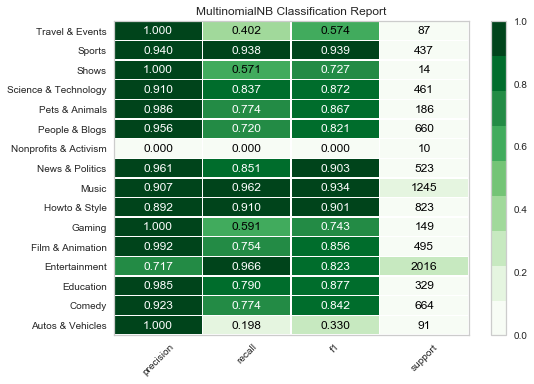

In [12]:
pred_tfidf = clf_tfidf.predict(x_test_tfidf_vector)
print("Tfidf Model")
print("Accuracy: ", accuracy_score(y_test, pred_tfidf))
print("Precision: ", metrics.precision_score(y_test, pred_tfidf, average='weighted'))
print("F1: ", metrics.f1_score(y_test, pred_tfidf, average='weighted'))
print(metrics.classification_report(y_test, pred_tfidf))


visualizer = ClassificationReport(clf_tfidf, support=True, cmap='Greens')
visualizer.fit(x_trained_tfidf_vector, y_train)
visualizer.score(x_test_tfidf_vector, y_test)
visualizer.show()

Count Model
Accuracy:  0.8996336996336997
Precision:  0.9007077699892384
F1:  0.8989440396735326
                       precision    recall  f1-score   support

     Autos & Vehicles       0.93      0.75      0.83        91
               Comedy       0.91      0.82      0.86       664
            Education       0.91      0.95      0.93       329
        Entertainment       0.89      0.89      0.89      2016
     Film & Animation       0.93      0.88      0.90       495
               Gaming       0.96      0.89      0.92       149
        Howto & Style       0.85      0.92      0.89       823
                Music       0.92      0.96      0.94      1245
      News & Politics       0.92      0.93      0.92       523
Nonprofits & Activism       1.00      0.20      0.33        10
       People & Blogs       0.91      0.83      0.87       660
       Pets & Animals       0.94      0.89      0.91       186
 Science & Technology       0.87      0.92      0.89       461
                Show

C:\Users\lukev\Anaconda3\envs\yt-trends\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


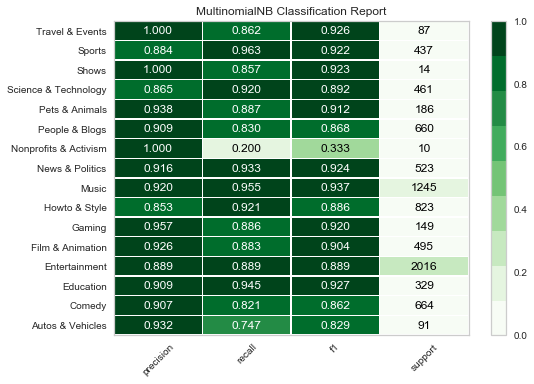

In [13]:
pred_count = clf_count.predict(test_count_vector)
print("Count Model")
print("Accuracy: ", accuracy_score(y_test, pred_count))
print("Precision: ", metrics.precision_score(y_test, pred_count, average='weighted'))
print("F1: ", metrics.f1_score(y_test, pred_count, average='weighted'))
print(metrics.classification_report(y_test, pred_count))


plt.title("Testing")
visualizer = ClassificationReport(clf_count, support=True, cmap='Greens')
visualizer.fit(train_count_vector, y_train)
visualizer.score(test_count_vector, y_test)
visualizer.finalize(set_title="this")

Tfidf Model
Accuracy:  0.9046398046398046
Precision:  0.9057277879908886
F1:  0.9043324194137408
                       precision    recall  f1-score   support

     Autos & Vehicles       0.94      0.79      0.86        91
               Comedy       0.92      0.84      0.88       664
            Education       0.97      0.93      0.95       329
        Entertainment       0.89      0.88      0.89      2016
     Film & Animation       0.93      0.89      0.91       495
               Gaming       0.96      0.89      0.93       149
        Howto & Style       0.86      0.93      0.89       823
                Music       0.91      0.96      0.93      1245
      News & Politics       0.92      0.93      0.92       523
Nonprofits & Activism       1.00      0.60      0.75        10
       People & Blogs       0.91      0.85      0.88       660
       Pets & Animals       0.94      0.92      0.93       186
 Science & Technology       0.87      0.94      0.90       461
                Show

C:\Users\lukev\Anaconda3\envs\yt-trends\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


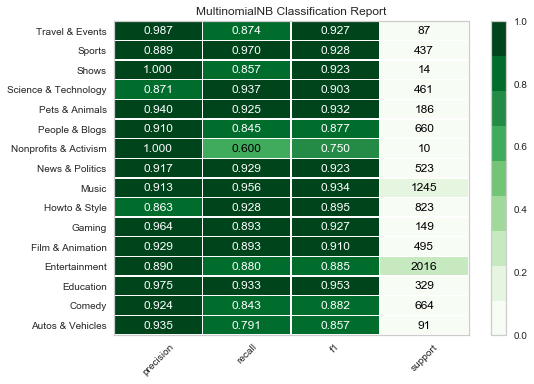

In [14]:
pred_count_stop = clf_count_stop.predict(test_count_vector_stop)
print("Tfidf Model")
print("Accuracy: ", accuracy_score(y_test, pred_count_stop))
print("Precision: ", metrics.precision_score(y_test, pred_count_stop, average='weighted'))
print("F1: ", metrics.f1_score(y_test, pred_count_stop, average='weighted'))
print(metrics.classification_report(y_test, pred_count_stop))


visualizer = ClassificationReport(clf_count_stop, support=True, cmap='Greens')
visualizer.fit(train_count_vector_stop, y_train)
visualizer.score(test_count_vector_stop, y_test)
visualizer.show()

### Confusion Matrix

C:\Users\lukev\Anaconda3\envs\yt-trends\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


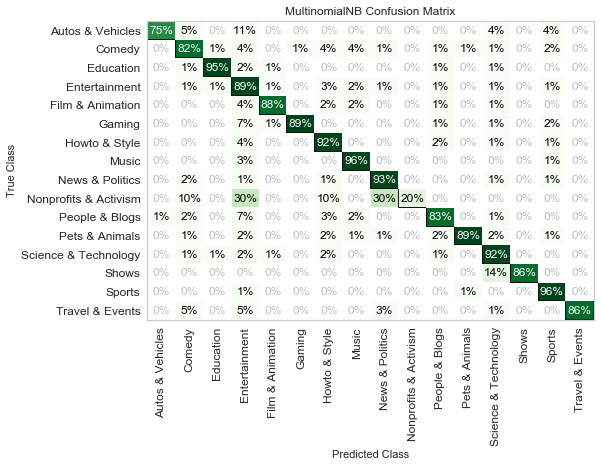

C:\Users\lukev\Anaconda3\envs\yt-trends\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


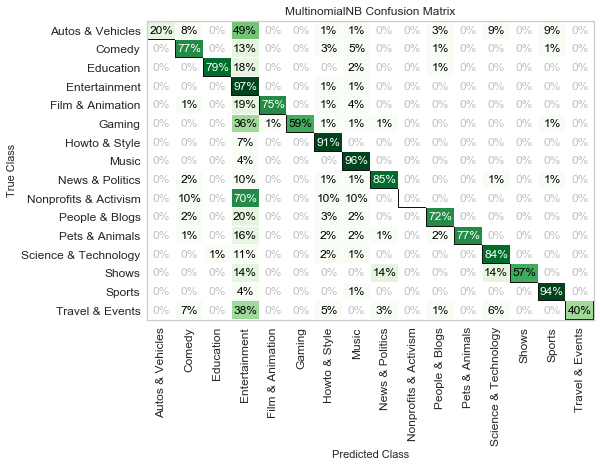

C:\Users\lukev\Anaconda3\envs\yt-trends\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


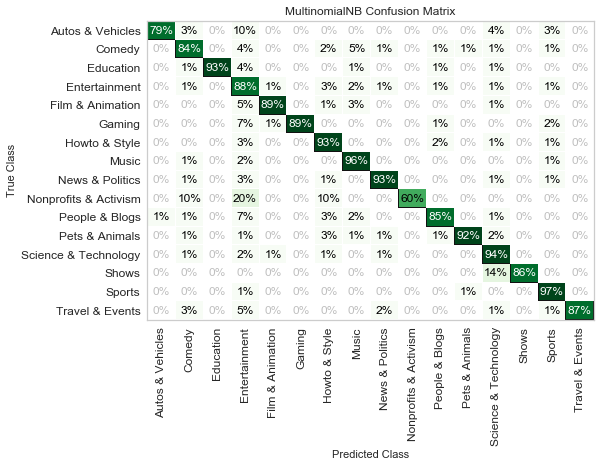

In [15]:
# conf_matrix = confusion_matrix(y_test, pred_count, labels=target_names)
# conf_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)

# plt.figure(figsize=(15,6))
# sns.heatmap(conf_df, cmap='YlOrRd', annot=True, fmt='d')
# plt.title('Multinomial Naive Bayes Count\nAccuracy:{0:.3f}'.format(accuracy_score(y_test, pred_count)))
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show()

# conf_matrix = confusion_matrix(y_test, pred_tfidf, labels=target_names)
# conf_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)

# plt.figure(figsize=(15,6))
# sns.heatmap(conf_df, cmap='YlOrRd', annot=True, fmt='d')
# plt.title('Multinomial Naive Bayes Vector\nAccuracy:{0:.3f}'.format(accuracy_score(y_test, pred_tfidf)))
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show()


conf_matrix = ConfusionMatrix(clf_count, percent=True, cmap='Greens')
conf_matrix.fit(train_count_vector, y_train)
conf_matrix.score(test_count_vector, y_test)
conf_matrix.show()

conf_matrix = ConfusionMatrix(clf_tfidf, percent=True, cmap='Greens')
conf_matrix.fit(x_trained_tfidf_vector, y_train)
conf_matrix.score(x_test_tfidf_vector, y_test)
conf_matrix.show()

conf_matrix = ConfusionMatrix(clf_count_stop, percent=True, cmap='Greens')
conf_matrix.fit(train_count_vector_stop, y_train)
conf_matrix.score(test_count_vector_stop, y_test)
conf_matrix.show()

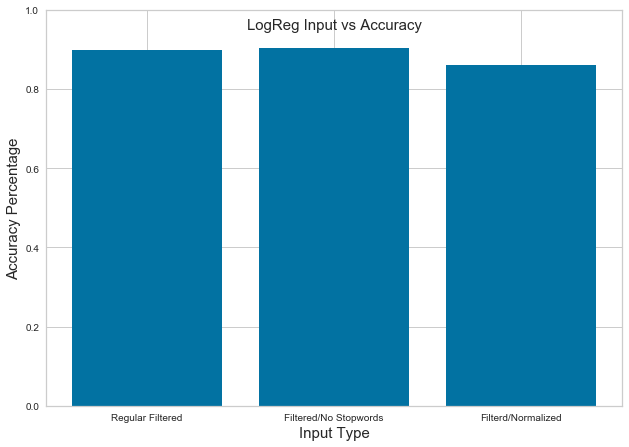

In [16]:
normalized_accuracy = accuracy_score(y_test, pred_tfidf)
regular_accuracy = accuracy_score(y_test, pred_count)
regular_accuracy_stop = accuracy_score(y_test, pred_count_stop)


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.ylim(0, 1)
x = ["Regular Filtered", "Filtered/No Stopwords", "Filterd/Normalized"]
y = [regular_accuracy, regular_accuracy_stop, normalized_accuracy]

fig.suptitle('LogReg Input vs Accuracy', fontsize=15)
plt.xlabel('Input Type', fontsize=15)
plt.ylabel('Accuracy Percentage', fontsize=15)
ax.bar(x,y)
plt.show()

C:\Users\lukev\Anaconda3\envs\yt-trends\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


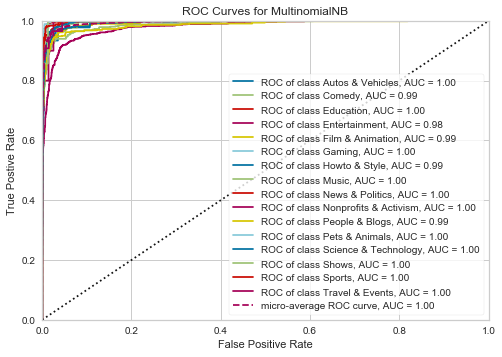

In [17]:
roc_count = ROCAUC(clf_count, macro=False)
roc_count.fit(train_count_vector, y_train)
roc_count.score(test_count_vector, y_test)
roc_count.show()

### Utilize SMOTE to oversample minority classes

Entertainment            7948
Music                    5227
Howto & Style            3323
Comedy                   2793
People & Blogs           2550
News & Politics          1964
Science & Technology     1940
Film & Animation         1850
Sports                   1737
Education                1327
Pets & Animals            734
Gaming                    668
Travel & Events           315
Autos & Vehicles          293
Nonprofits & Activism      47
Shows                      43
Name: category_id, dtype: int64

Pets & Animals           7948
Howto & Style            7948
Comedy                   7948
Entertainment            7948
Gaming                   7948
Sports                   7948
Autos & Vehicles         7948
News & Politics          7948
Travel & Events          7948
People & Blogs           7948
Music                    7948
Education                7948
Shows                    7948
Film & Animation         7948
Science & Technology     7948
Nonprofits & Activism    7948
Name: c

C:\Users\lukev\Anaconda3\envs\yt-trends\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


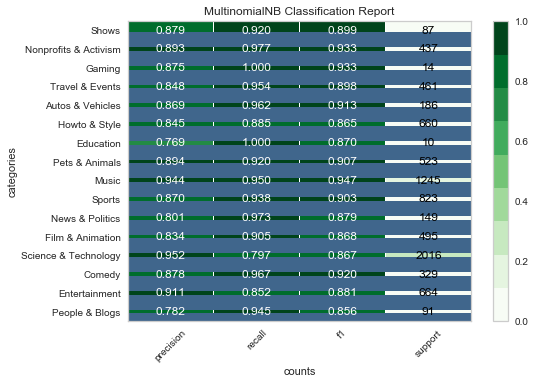

C:\Users\lukev\Anaconda3\envs\yt-trends\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


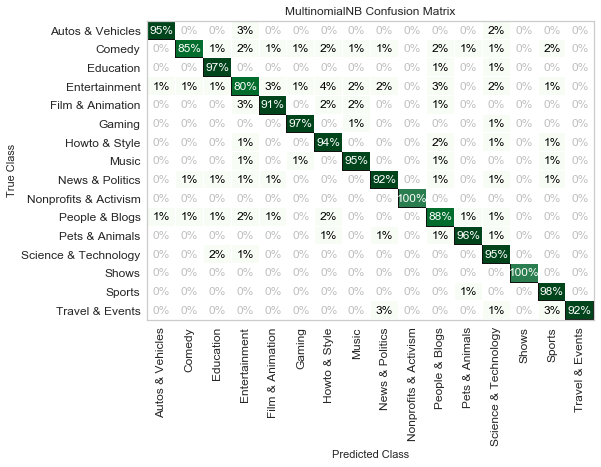

In [18]:
smote = SMOTE(sampling_strategy='not majority')

x_train_smote, y_train_smote = smote.fit_sample(train_count_vector, y_train)

print(y_train.value_counts())
print()
print(y_train_smote.value_counts())
print()
print(y_test.value_counts())


norm_smp = y_train.value_counts().rename_axis('categories').reset_index(name='counts')
plot_norm = sns.barplot(x='counts', y='categories',data=norm_smp, color=(0.2, 0.4, 0.6, 0.6))

over_smp = y_train_smote.value_counts().rename_axis('categories').reset_index(name='counts')
plot_over = sns.barplot(x='counts', y='categories',data=over_smp, color=(0.2, 0.4, 0.6, 0.6))

clf_count.fit(x_train_smote, y_train_smote)

pred_count_smote = clf_count.predict(test_count_vector)
print("Count Model")
print("Accuracy: ", accuracy_score(y_test, pred_count_smote))
print("Precision: ", metrics.precision_score(y_test, pred_count_smote, average='weighted'))
print("F1: ", metrics.f1_score(y_test, pred_count_smote, average='weighted'))
print(metrics.classification_report(y_test, pred_count_smote, target_names=target_names))


visualizer = ClassificationReport(clf_count, classes=target_names, support=True, cmap='Greens')
visualizer.fit(x_train_smote, y_train_smote)
visualizer.score(test_count_vector, y_test)
visualizer.show()


conf_matrix = ConfusionMatrix(clf_count, cmap='Greens', percent=True)
conf_matrix.fit(x_train_smote, y_train_smote)
conf_matrix.score(test_count_vector, y_test)
conf_matrix.show()



In [19]:
pipe_count = Pipeline([
    ('count', CountVectorizer()),
    ('classify', MultinomialNB())
])

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, stratify=df_y, random_state=117)
print(y_train.value_counts())
# print(y_test.value_counts())

pipe_count.fit(x_train, y_train)

Entertainment            7971
Music                    5177
Howto & Style            3317
Comedy                   2765
People & Blogs           2568
News & Politics          1989
Science & Technology     1921
Film & Animation         1876
Sports                   1739
Education                1325
Pets & Animals            736
Gaming                    654
Travel & Events           322
Autos & Vehicles          307
Shows                      46
Nonprofits & Activism      46
Name: category_id, dtype: int64


Pipeline(memory=None,
         steps=[('count',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classify',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [20]:
y_pred = pipe_count.predict(x_test)
print(metrics.classification_report(y_test, y_pred))

                       precision    recall  f1-score   support

     Autos & Vehicles       0.92      0.77      0.84        77
               Comedy       0.92      0.84      0.88       692
            Education       0.87      0.92      0.90       331
        Entertainment       0.89      0.88      0.88      1993
     Film & Animation       0.92      0.87      0.90       469
               Gaming       0.99      0.91      0.95       163
        Howto & Style       0.86      0.94      0.90       829
                Music       0.93      0.97      0.95      1295
      News & Politics       0.90      0.90      0.90       498
Nonprofits & Activism       1.00      0.09      0.17        11
       People & Blogs       0.88      0.82      0.85       642
       Pets & Animals       0.95      0.89      0.92       184
 Science & Technology       0.85      0.89      0.87       480
                Shows       1.00      0.82      0.90        11
               Sports       0.91      0.97      0.94  